In [3]:
# Step 1: Install gdown
!pip install -q gdown

# Step 2: Download the ZIP file from your Google Drive link
!gdown --id 1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg -O Main.zip

# Step 3: Unzip into /content/dataset
!unzip -q Main.zip -d /content/dataset

# Step 4: List extracted folders to verify
!ls /content/dataset

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg
From (redirected): https://drive.google.com/uc?id=1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg&confirm=t&uuid=e1890960-f5d0-4ff1-a537-a1c008eb72b5
To: /content/Main.zip
100% 5.10G/5.10G [00:31<00:00, 162MB/s]
Main


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

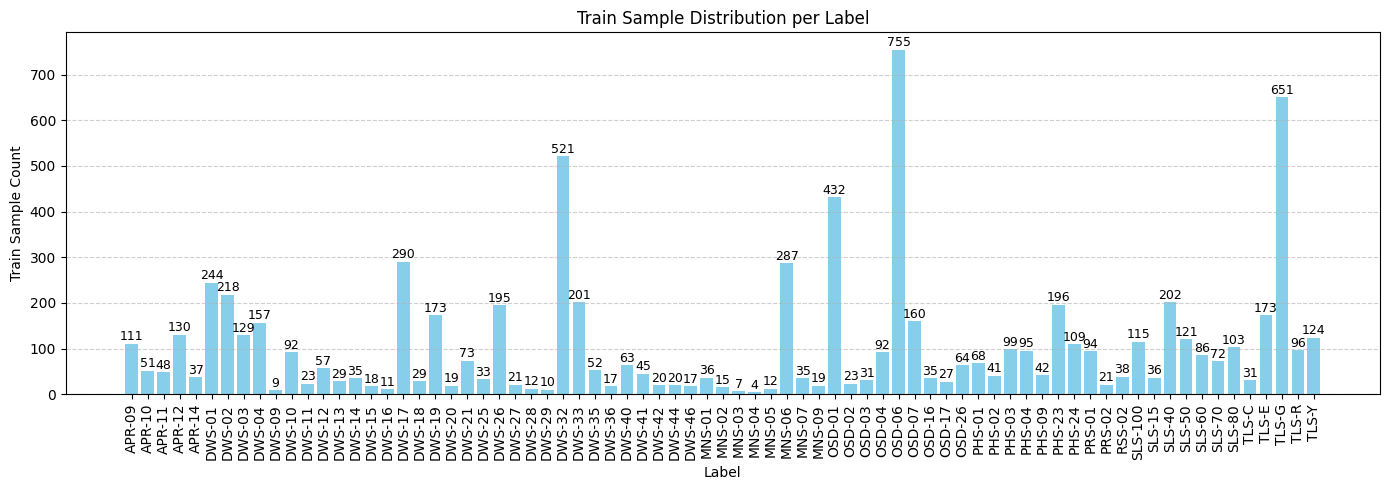

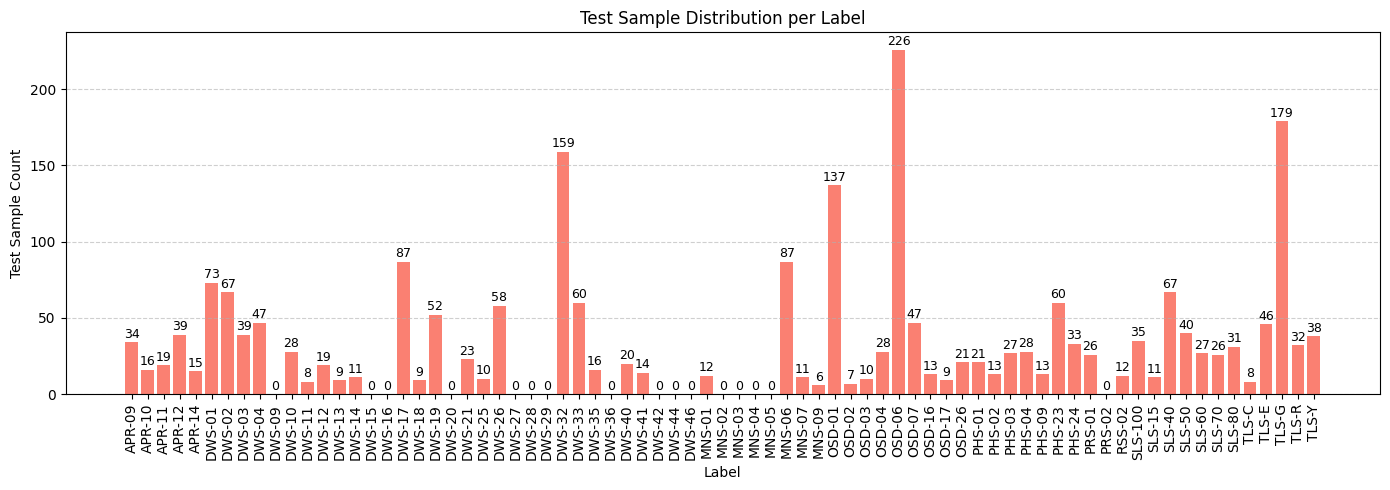

In [14]:
# Load and clean the data
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')
df = df.drop(columns=['Total'])
df = df[df['Label'].str.lower() != 'total']

# --- Plot Train Distribution ---
plt.figure(figsize=(14, 5))
bars = plt.bar(df['Label'], df['Train'], color='skyblue')
plt.title('Train Sample Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Train Sample Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# --- Plot Test Distribution ---
plt.figure(figsize=(14, 5))
bars = plt.bar(df['Label'], df['Test'], color='salmon')
plt.title('Test Sample Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Test Sample Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [15]:
!ls /content/dataset/Main

'label_frequencies.xlsx - Label Frequencies.csv'   sample   test   train


In [17]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd

# Define base dataset directory
base_dir = './dataset/Main'

# Create destination structure
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(f'./final_dataset/{split}/images', exist_ok=True)
    os.makedirs(f'./final_dataset/{split}/labels', exist_ok=True)

# Read class labels from Excel
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')
df = df.drop(columns=['Total'], errors='ignore')
df = df[df['Label'].str.lower() != 'total']
class_list = df['Label'].tolist()

# XML to YOLO format conversion
def convert_and_move(source_dir, img_files, target_split):
    for file in img_files:
        img_path = os.path.join(source_dir, file)
        xml_path = os.path.join(source_dir, file.replace('.jpg', '.xml'))

        if not os.path.exists(xml_path):
            continue

        # Copy image
        shutil.copy(img_path, f'./final_dataset/{target_split}/images/{file}')

        # Convert XML to YOLO
        tree = ET.parse(xml_path)
        root = tree.getroot()
        width = int(root.find("size/width").text)
        height = int(root.find("size/height").text)

        with open(f'./final_dataset/{target_split}/labels/{file.replace(".jpg", ".txt")}', "w") as f:
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                if class_name not in class_list:
                    continue
                class_id = class_list.index(class_name)

                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                cx = ((xmin + xmax) / 2) / width
                cy = ((ymin + ymax) / 2) / height
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height

                f.write(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

# Process train set
train_dir = os.path.join(base_dir, 'train')
train_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
convert_and_move(train_dir, train_images, 'train')

# Split test into test and val (50/50)
test_dir = os.path.join(base_dir, 'test')
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
mid = len(test_images) // 2
val_images = test_images[:mid]
test_images = test_images[mid:]

convert_and_move(test_dir, val_images, 'val')
convert_and_move(test_dir, test_images, 'test')

<Figure size 1600x600 with 0 Axes>

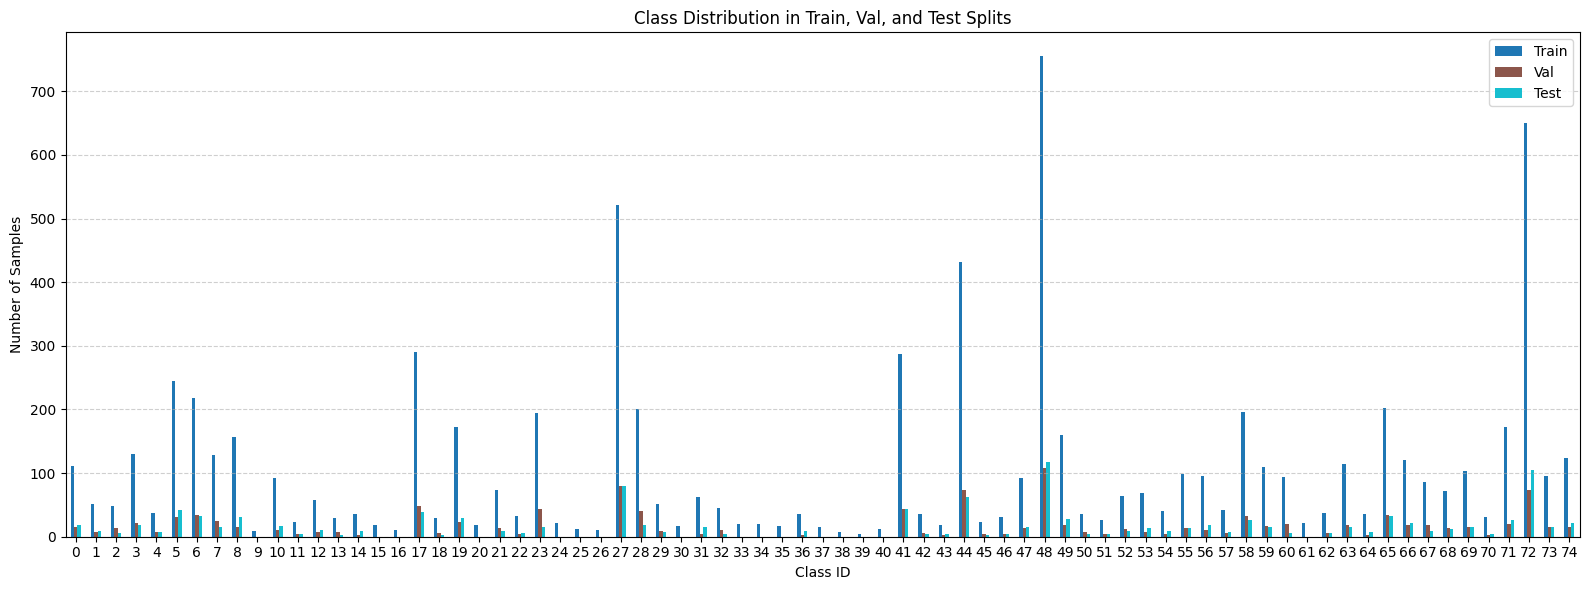

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Define label folder paths
label_dirs = {
    'Train': './final_dataset/train/labels',
    'Val': './final_dataset/val/labels',
    'Test': './final_dataset/test/labels'
}

# Count class occurrences for each split
split_counts = {}
for split_name, label_path in label_dirs.items():
    class_counter = Counter()
    for file in os.listdir(label_path):
        if file.endswith('.txt'):
            with open(os.path.join(label_path, file), 'r') as f:
                for line in f:
                    if line.strip():
                        try:
                            class_id = int(line.strip().split()[0])
                            class_counter[class_id] += 1
                        except ValueError:
                            continue
    split_counts[split_name] = class_counter

# Convert to DataFrame
df_dist = pd.DataFrame(split_counts).fillna(0).astype(int)
df_dist.index.name = 'Class ID'
df_dist = df_dist.sort_index()

# Plotting
plt.figure(figsize=(16, 6))
df_dist.plot(kind='bar', figsize=(16, 6), colormap='tab10')
plt.title('Class Distribution in Train, Val, and Test Splits')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [20]:
import pandas as pd

# Load class names from your Excel file
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')

# Drop "Total" column and row if present
df = df.drop(columns=['Total'], errors='ignore')
df = df[df['Label'].str.lower() != 'total']

# Generate the 'names' YAML section
print("names:")
for idx, name in enumerate(df['Label']):
    print(f"  {idx}: {name}")


names:
  0: APR-09
  1: APR-10
  2: APR-11
  3: APR-12
  4: APR-14
  5: DWS-01
  6: DWS-02
  7: DWS-03
  8: DWS-04
  9: DWS-09
  10: DWS-10
  11: DWS-11
  12: DWS-12
  13: DWS-13
  14: DWS-14
  15: DWS-15
  16: DWS-16
  17: DWS-17
  18: DWS-18
  19: DWS-19
  20: DWS-20
  21: DWS-21
  22: DWS-25
  23: DWS-26
  24: DWS-27
  25: DWS-28
  26: DWS-29
  27: DWS-32
  28: DWS-33
  29: DWS-35
  30: DWS-36
  31: DWS-40
  32: DWS-41
  33: DWS-42
  34: DWS-44
  35: DWS-46
  36: MNS-01
  37: MNS-02
  38: MNS-03
  39: MNS-04
  40: MNS-05
  41: MNS-06
  42: MNS-07
  43: MNS-09
  44: OSD-01
  45: OSD-02
  46: OSD-03
  47: OSD-04
  48: OSD-06
  49: OSD-07
  50: OSD-16
  51: OSD-17
  52: OSD-26
  53: PHS-01
  54: PHS-02
  55: PHS-03
  56: PHS-04
  57: PHS-09
  58: PHS-23
  59: PHS-24
  60: PRS-01
  61: PRS-02
  62: RSS-02
  63: SLS-100
  64: SLS-15
  65: SLS-40
  66: SLS-50
  67: SLS-60
  68: SLS-70
  69: SLS-80
  70: TLS-C
  71: TLS-E
  72: TLS-G
  73: TLS-R
  74: TLS-Y


In [21]:
!pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 134.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [23]:
from ultralytics import YOLO

# Load the YOLOv12n model (pretrained)
model = YOLO('yolo12n.pt')

# Train the model
model.train(
    data='/content/final_dataset/data.yaml',  # 👈 path to your data.yaml
    epochs=100,                     # number of epochs
    imgsz=640,                      # input image size
    batch=32,                       # batch size
    project='runs/train',          # directory to save results
    name='yolo12n_custom',         # experiment name
    verbose=True                   # show training logs
)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo12n_custom2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=

100%|██████████| 755k/755k [00:00<00:00, 84.8MB/s]

Overriding model.yaml nc=80 with nc=75

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytic

YOLOv12n summary: 272 layers, 2,595,158 parameters, 2,595,142 gradients, 6.6 GFLOPs

Transferred 640/691 items from pretrained weights
Freezing layer 'model.21.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 343MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3035.4±2055.8 MB/s, size: 650.3 KB)


train: Scanning /content/final_dataset/train/labels... 6143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6143/6143 [00:03<00:00, 1594.01it/s]


train: New cache created: /content/final_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2755.5±1760.5 MB/s, size: 586.1 KB)


val: Scanning /content/final_dataset/val/labels... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<00:00, 1287.03it/s]

val: New cache created: /content/final_dataset/val/labels.cache


Plotting labels to runs/train/yolo12n_custom2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000127, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/yolo12n_custom2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       6.5G      1.366      6.438     0.9683         74        640: 100%|██████████| 192/192 [01:10<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.07it/s]

                   all        920       1155      0.568     0.0595     0.0379     0.0288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.71G      1.324      5.101     0.9358         57        640: 100%|██████████| 192/192 [01:06<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


                   all        920       1155      0.405      0.147     0.0777       0.06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.72G      1.217      4.166     0.9175         85        640: 100%|██████████| 192/192 [01:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


                   all        920       1155      0.506      0.173      0.128      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.74G      1.188      3.564     0.9111         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


                   all        920       1155      0.518      0.236      0.204      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.75G      1.117      3.016     0.9019         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

                   all        920       1155      0.615       0.28      0.264      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.77G      1.072      2.662     0.8949         68        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]

                   all        920       1155      0.442      0.354      0.303      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.78G      1.058      2.416     0.8946         63        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]

                   all        920       1155      0.458      0.415      0.364      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.79G      1.043      2.289     0.8898         74        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


                   all        920       1155      0.524      0.409      0.386      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.81G      1.031      2.091     0.8911         85        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

                   all        920       1155      0.504       0.46      0.421      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.83G      1.004      1.956     0.8855         59        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

                   all        920       1155      0.599      0.454      0.457      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.84G     0.9912      1.808     0.8804         70        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        920       1155       0.55      0.446       0.46      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.86G     0.9696      1.695     0.8798         54        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


                   all        920       1155      0.656      0.457      0.485      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.87G     0.9553      1.601     0.8738         64        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


                   all        920       1155      0.687      0.466      0.505      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.88G     0.9628      1.573     0.8765         68        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

                   all        920       1155      0.606      0.523      0.521      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       6.9G     0.9368      1.443     0.8729         75        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


                   all        920       1155      0.674      0.494      0.529      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.92G     0.9468       1.42     0.8731         70        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


                   all        920       1155      0.628      0.524      0.559      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.93G     0.9486      1.375     0.8748         76        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

                   all        920       1155      0.704      0.525      0.573      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.95G     0.9092      1.276     0.8711         84        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]

                   all        920       1155      0.663      0.551      0.581      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.96G     0.9163      1.264     0.8707         62        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

                   all        920       1155      0.663      0.539      0.577      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.97G     0.9166      1.223     0.8684         81        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


                   all        920       1155      0.629      0.574        0.6       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.99G     0.8973      1.151     0.8667         70        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

                   all        920       1155      0.777      0.531      0.602       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         7G     0.9065      1.141     0.8681         52        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

                   all        920       1155      0.825      0.527       0.63      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.02G     0.8922      1.106      0.864         78        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

                   all        920       1155      0.715      0.577      0.627      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.03G      0.889      1.082     0.8625         72        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]

                   all        920       1155      0.745      0.569      0.637      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.05G     0.8786      1.036     0.8628         72        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

                   all        920       1155       0.76       0.57      0.641      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.06G     0.8882      1.036     0.8622         67        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


                   all        920       1155       0.82      0.526      0.622      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.08G      0.858     0.9907     0.8577         73        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]

                   all        920       1155      0.768      0.585      0.652      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.09G      0.861     0.9571     0.8587         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


                   all        920       1155      0.833      0.569      0.661      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.11G     0.8597     0.9576     0.8593         72        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


                   all        920       1155      0.849      0.565      0.678      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.12G     0.8626     0.9346     0.8591         74        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]

                   all        920       1155      0.755      0.598      0.668      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.14G     0.8473     0.9177     0.8582         62        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


                   all        920       1155      0.757      0.614      0.694      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.15G     0.8474     0.8934     0.8523         69        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


                   all        920       1155      0.841      0.581      0.685      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.17G     0.8532     0.9012     0.8561         69        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.75it/s]

                   all        920       1155      0.744      0.617      0.681      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.18G     0.8378     0.8592     0.8533         47        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

                   all        920       1155      0.785      0.617      0.694      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       7.2G     0.8259     0.8518      0.853         54        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

                   all        920       1155      0.838      0.617      0.691      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.21G     0.8346     0.8446     0.8533         79        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]

                   all        920       1155      0.821      0.621      0.708      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.23G     0.8227     0.8221     0.8481         70        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

                   all        920       1155      0.834      0.621      0.715      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.24G     0.8355     0.8224     0.8551         70        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

                   all        920       1155      0.771      0.631      0.707       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.26G     0.8208     0.7996     0.8508         56        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

                   all        920       1155      0.844      0.639      0.725      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.27G     0.8232     0.7997     0.8492         71        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

                   all        920       1155      0.834      0.639      0.725       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.29G     0.8099     0.7819     0.8459         67        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


                   all        920       1155      0.842      0.628      0.721      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       7.3G     0.8266     0.7806     0.8508         60        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


                   all        920       1155      0.848      0.646      0.736       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.32G     0.8283     0.7822     0.8515         62        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


                   all        920       1155      0.843       0.61      0.712      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.33G     0.8217     0.7676     0.8508         72        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

                   all        920       1155      0.849      0.648      0.744      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.35G     0.8005     0.7426     0.8462         60        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]

                   all        920       1155      0.805      0.663      0.737      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.36G     0.7986     0.7359     0.8447         69        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

                   all        920       1155      0.784      0.675       0.74      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.38G     0.8052     0.7386     0.8481         51        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        920       1155      0.796      0.664      0.751      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.39G     0.7991      0.722     0.8444         81        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

                   all        920       1155      0.827      0.657      0.744      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.41G     0.7862     0.7027     0.8442         78        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        920       1155      0.779      0.696      0.744      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.42G     0.7787     0.6983     0.8438         60        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]

                   all        920       1155      0.864      0.664      0.753      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.44G     0.7793     0.6967     0.8437         52        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]

                   all        920       1155      0.814      0.673      0.745      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.45G     0.7909     0.6941     0.8453         67        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

                   all        920       1155      0.813      0.688      0.755      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.47G     0.7694     0.6668     0.8393         75        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

                   all        920       1155      0.818      0.642      0.746        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.48G     0.7728     0.6763     0.8387         75        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]

                   all        920       1155      0.861      0.649       0.75      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       7.5G     0.7637     0.6682     0.8389         70        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

                   all        920       1155      0.837      0.658      0.753      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.51G     0.7755     0.6707     0.8432         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]

                   all        920       1155      0.843       0.65      0.742      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.53G     0.7584     0.6595     0.8368         82        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

                   all        920       1155      0.836      0.686      0.763      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.54G     0.7673     0.6501      0.841         69        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

                   all        920       1155      0.801      0.694      0.756        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.56G     0.7609     0.6544     0.8392         66        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


                   all        920       1155      0.807      0.671      0.746      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.57G     0.7549     0.6361     0.8351         61        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

                   all        920       1155      0.821      0.679      0.748      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.59G     0.7511     0.6308     0.8356         71        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]

                   all        920       1155      0.834      0.681       0.76      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       7.6G     0.7502     0.6333     0.8373         71        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

                   all        920       1155      0.819      0.697      0.764      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.62G     0.7469     0.6309     0.8333         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

                   all        920       1155      0.828      0.678       0.76      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.63G     0.7453     0.6204     0.8311         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]

                   all        920       1155      0.832      0.682      0.763       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.65G     0.7496     0.6266     0.8351         79        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        920       1155      0.821      0.688      0.766      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.66G     0.7494     0.6227     0.8342         68        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]

                   all        920       1155       0.84      0.695      0.769       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.68G     0.7356     0.6124      0.834         75        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

                   all        920       1155      0.845      0.693       0.77      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.69G     0.7412     0.6078     0.8318         70        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]

                   all        920       1155      0.894      0.665      0.762      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.71G     0.7423       0.61     0.8335         72        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        920       1155      0.859      0.697      0.778       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.72G     0.7387     0.6039     0.8304         72        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        920       1155      0.879      0.686      0.782      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.74G     0.7372     0.6091      0.831         66        640: 100%|██████████| 192/192 [01:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]

                   all        920       1155      0.852      0.678      0.773      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.75G     0.7302     0.5981     0.8329         65        640: 100%|██████████| 192/192 [01:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        920       1155      0.859      0.691      0.777      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.77G      0.719     0.5861     0.8302         53        640: 100%|██████████| 192/192 [01:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]

                   all        920       1155      0.855      0.701      0.782      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.78G     0.7165     0.5785     0.8295         62        640: 100%|██████████| 192/192 [01:06<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]

                   all        920       1155      0.846      0.695      0.774      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.79G     0.7294     0.5931     0.8324         63        640: 100%|██████████| 192/192 [01:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]

                   all        920       1155      0.857        0.7      0.778      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.81G     0.7274     0.5902     0.8294         74        640: 100%|██████████| 192/192 [01:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]

                   all        920       1155      0.876       0.68      0.778      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.82G     0.7266     0.5815       0.83         74        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

                   all        920       1155      0.817      0.705      0.779      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.84G     0.7159     0.5727     0.8277         55        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        920       1155       0.82      0.713      0.779      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.86G     0.7247     0.5803     0.8323         72        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]

                   all        920       1155      0.834      0.699      0.781      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.87G     0.7122      0.579     0.8307         86        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        920       1155      0.852       0.69      0.787      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.88G     0.7099     0.5731     0.8292         73        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

                   all        920       1155      0.851      0.689      0.786      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       7.9G     0.7018     0.5653     0.8274         77        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

                   all        920       1155      0.863      0.689      0.785      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.91G     0.7029     0.5539     0.8272         66        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

                   all        920       1155      0.836      0.705      0.782      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.93G     0.6973       0.55     0.8265         74        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]

                   all        920       1155      0.857        0.7      0.787      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.95G     0.7018     0.5559     0.8258         73        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

                   all        920       1155      0.852      0.695      0.788      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.96G     0.6921     0.5467     0.8259         74        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

                   all        920       1155      0.863      0.704      0.792      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.97G     0.6934     0.5548     0.8258         62        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

                   all        920       1155       0.84      0.717      0.793      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.99G     0.6831     0.5446     0.8241         68        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


                   all        920       1155      0.825      0.723      0.792      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         8G     0.6946     0.5505     0.8261         73        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]

                   all        920       1155      0.853      0.709      0.792      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.02G     0.6934     0.5449     0.8245         68        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


                   all        920       1155      0.834      0.722      0.785      0.627
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.03G     0.7007     0.5634     0.8323         35        640: 100%|██████████| 192/192 [01:06<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]

                   all        920       1155      0.837      0.693       0.77      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.05G     0.6698     0.5137     0.8256         38        640: 100%|██████████| 192/192 [01:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


                   all        920       1155      0.828      0.707      0.775      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.06G     0.6645     0.5094     0.8205         35        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]

                   all        920       1155      0.876      0.686      0.785      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.08G     0.6695     0.5092     0.8274         34        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

                   all        920       1155      0.874      0.691      0.788       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.09G      0.656     0.4939     0.8204         34        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


                   all        920       1155      0.877      0.697      0.792      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.11G     0.6526     0.4959     0.8241         38        640: 100%|██████████| 192/192 [01:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


                   all        920       1155      0.876      0.703      0.796      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.12G     0.6497     0.4933     0.8232         49        640: 100%|██████████| 192/192 [01:06<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


                   all        920       1155      0.864      0.707      0.798      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.14G       0.65     0.4878     0.8192         38        640: 100%|██████████| 192/192 [01:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

                   all        920       1155      0.869      0.706      0.797      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.15G     0.6482     0.4857     0.8212         37        640: 100%|██████████| 192/192 [01:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

                   all        920       1155      0.874      0.707      0.798      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.17G     0.6436     0.4897     0.8236         37        640: 100%|██████████| 192/192 [01:09<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]

                   all        920       1155      0.875      0.708      0.799      0.635



100 epochs completed in 1.953 hours.
Optimizer stripped from runs/train/yolo12n_custom2/weights/last.pt, 5.6MB
Optimizer stripped from runs/train/yolo12n_custom2/weights/best.pt, 5.6MB

Validating runs/train/yolo12n_custom2/weights/best.pt...
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12n summary (fused): 159 layers, 2,583,739 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


                   all        920       1155      0.877      0.707      0.799      0.633
                APR-09         15         15      0.886      0.733      0.781      0.548
                APR-10          7          7      0.819      0.654      0.859      0.736
                APR-11         13         13      0.918       0.86      0.947      0.692
                APR-12         21         21      0.801      0.667      0.809       0.62
                APR-14          8          8          1      0.824      0.879      0.693
                DWS-01         31         31      0.955          1      0.984      0.876
                DWS-02         34         34      0.983      0.971      0.994      0.903
                DWS-03         24         24      0.955          1      0.995      0.888
                DWS-04         16         16      0.941      0.993      0.988      0.896
                DWS-10         11         11      0.852      0.909      0.968      0.792
                DWS-1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 17, 18, 19, 21, 22, 23, 27, 28, 29, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2bdc1b9590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

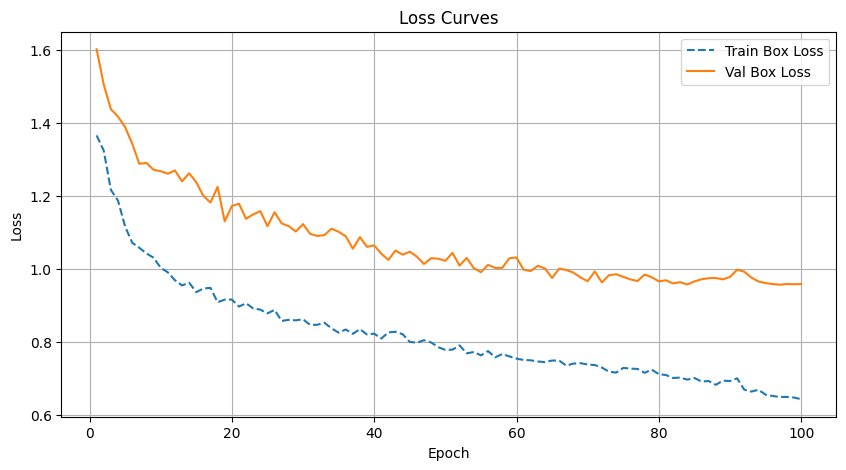

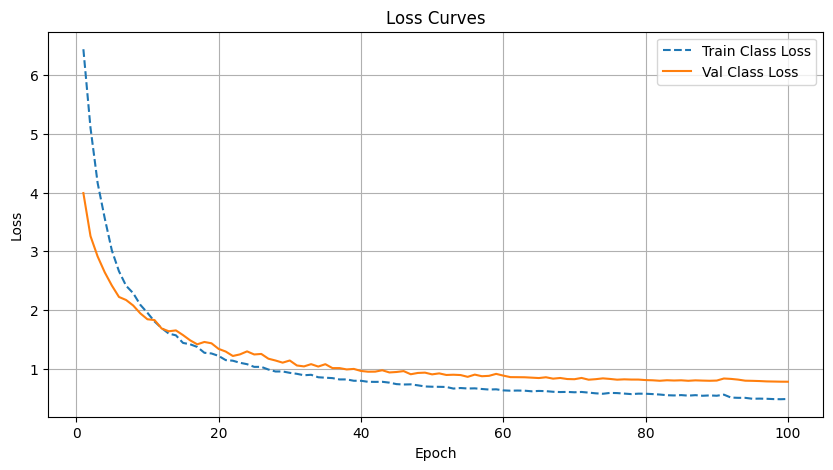

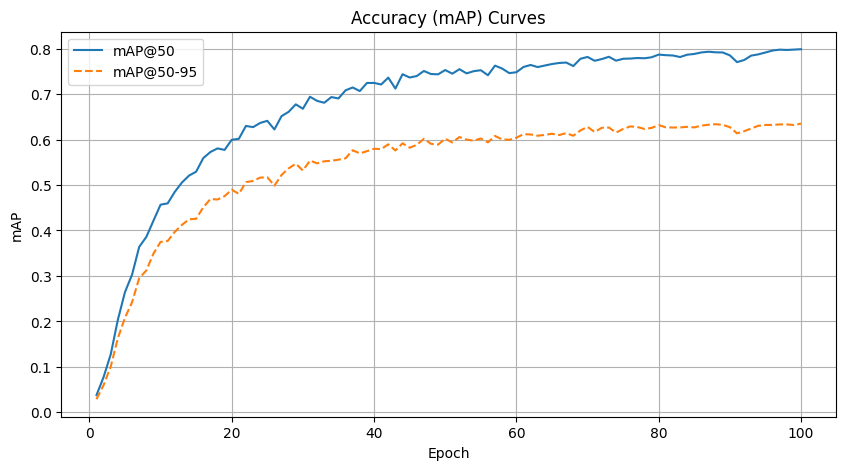

In [25]:
# Load the CSV file
results_path = "/content/runs/train/yolo12n_custom2/results.csv"  # Update path if needed
df = pd.read_csv(results_path)

# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# Now, plot the curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
# Plot mAP Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Accuracy (mAP) Curves')
plt.legend()
plt.grid()
plt.show()

In [26]:
model.tune(
    data='/content/final_dataset/data.yaml',
    epochs=30,
    imgsz=640,
    iterations=20,
    plots=True
)

Tuner: Initialized Tuner instance with 'tune_dir=runs/train/yolo12n_custom22'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/20 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'cutmix': 0.0, 'copy_paste': 0.0}


KeyboardInterrupt: 

In [27]:
model.tune(
    data='/content/final_dataset/data.yaml',
    imgsz=320,         # ✅ smaller size = faster epochs
    epochs=10,         # ✅ reduce time per trial
    iterations=10,     # ✅ faster overall tuning
    batch=32,
    plots=True,
    name='yolo12n_tune_fast'
)

Tuner: Initialized Tuner instance with 'tune_dir=runs/train/yolo12n_tune_fast'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'cutmix': 0.0, 'copy_paste': 0.0}
Saved runs/train/yolo12n_tune_fast/tune_scatter_plots.png
Saved runs/train/yolo12n_tune_fast/tune_fitness.png

Tuner: 1/10 iterations complete ✅ (358.84s)
Tuner: Results saved to runs/train/yolo12n_tune_fast
Tuner: Best fitness=0.12296 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.45272, 'metrics/recall(B)': 0.21439, 'metrics/mAP50(B)': 0.16313, 'metrics/mA

In [29]:
!ls /content/runs/train/yolo12n_tune_fast

best_hyperparameters.yaml  tune_results.csv	   weights
tune_fitness.png	   tune_scatter_plots.png


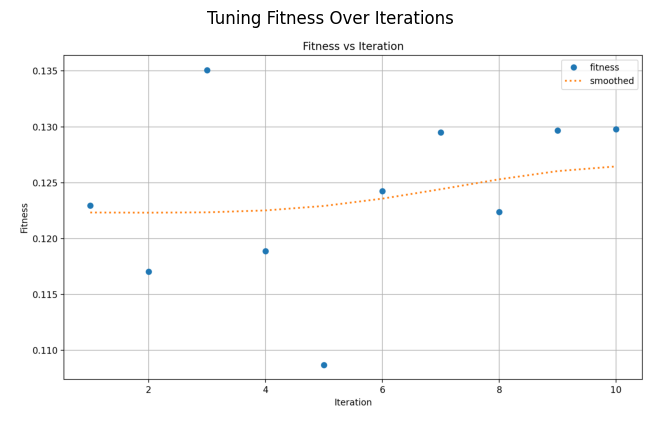

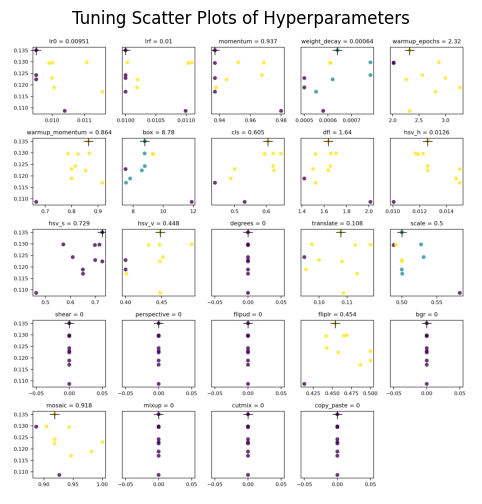

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fitness_path = '/content/runs/train/yolo12n_tune_fast/tune_fitness.png'
scatter_path = '/content/runs/train/yolo12n_tune_fast/tune_scatter_plots.png'

plt.figure(figsize=(10, 5))
plt.imshow(mpimg.imread(fitness_path))
plt.title("Tuning Fitness Over Iterations")
plt.axis('off')
plt.show()

print(" ")

plt.figure(figsize=(12, 6))
plt.imshow(mpimg.imread(scatter_path))
plt.title("Tuning Scatter Plots of Hyperparameters")
plt.axis('off')
plt.show()


In [34]:
import yaml

# Load the best hyperparameters
with open('/content/runs/train/yolo12n_tune_fast/best_hyperparameters.yaml', 'r') as f:
    best_hyp = yaml.safe_load(f)

In [35]:
from ultralytics import YOLO

model = YOLO('yolo12n.pt')

model.train(
    data='/content/final_dataset/data.yaml',
    epochs=200,
    imgsz=640,
    batch=64,
    patience=10,
    lr0=best_hyp['lr0'],
    lrf=best_hyp['lrf'],
    momentum=best_hyp['momentum'],
    weight_decay=best_hyp['weight_decay'],
    warmup_epochs=best_hyp['warmup_epochs'],
    warmup_momentum=best_hyp['warmup_momentum'],
    box=best_hyp['box'],
    cls=best_hyp['cls'],
    dfl=best_hyp['dfl'],
    hsv_h=best_hyp['hsv_h'],
    hsv_s=best_hyp['hsv_s'],
    hsv_v=best_hyp['hsv_v'],
    degrees=best_hyp['degrees'],
    translate=best_hyp['translate'],
    scale=best_hyp['scale'],
    shear=best_hyp['shear'],
    perspective=best_hyp['perspective'],
    flipud=best_hyp['flipud'],
    fliplr=best_hyp['fliplr'],
    bgr=best_hyp['bgr'],
    mosaic=best_hyp['mosaic'],
    mixup=best_hyp['mixup'],
    cutmix=best_hyp['cutmix'],
    copy_paste=best_hyp['copy_paste'],
    project='runs/train',
    name='yolo12n_final_tuned'
)


Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=8.77808, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.60548, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.6372, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.45382, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01259, hsv_s=0.7287, hsv_v=0.44796, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00951, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=0.91831, multi_scale=False, name=yolo12n_final_tuned, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, 

train: Scanning /content/final_dataset/train/labels.cache... 6143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6143/6143 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1579.8±1380.2 MB/s, size: 586.1 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]


Plotting labels to runs/train/yolo12n_final_tuned/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00951' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00064), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/yolo12n_final_tuned
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      13.4G      1.603      7.047       1.06        128        640: 100%|██████████| 96/96 [01:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.41it/s]

                   all        920       1155     0.0254     0.0316     0.0223      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      13.2G      1.625      5.279      1.071        137        640:  93%|█████████▎| 89/96 [01:02<00:04,  1.43it/s]


KeyboardInterrupt: 

In [36]:
from ultralytics import YOLO

# Load YOLOv12n model
model = YOLO('yolo12n.pt')

# Train using tuned hyperparameters
model.train(
    data='/content/final_dataset/data.yaml',
    epochs=200,
    imgsz=640,
    batch=64,
    optimizer='SGD',
    lr0=0.00951,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.00064,
    warmup_epochs=2.3222,
    warmup_momentum=0.86382,
    box=8.77808,
    cls=0.60548,
    dfl=1.6372,
    hsv_h=0.01259,
    hsv_s=0.7287,
    hsv_v=0.44796,
    degrees=0.0,
    translate=0.10775,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.45382,
    bgr=0.0,
    mosaic=0.91831,
    mixup=0.0,
    cutmix=0.0,
    copy_paste=0.0,
    project='runs/train',
    name='yolo12n_final_tuned',
    verbose=True
)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=8.77808, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.60548, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.6372, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.45382, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01259, hsv_s=0.7287, hsv_v=0.44796, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00951, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=0.91831, multi_scale=False, name=yolo12n_final_tuned2, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=100,

train: Scanning /content/final_dataset/train/labels.cache... 6143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6143/6143 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 1675.2±1343.5 MB/s, size: 586.1 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]


Plotting labels to runs/train/yolo12n_final_tuned2/labels.jpg... 
optimizer: SGD(lr=0.00951, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00064), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/yolo12n_final_tuned2
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      13.8G        1.6      6.948      1.057        128        640: 100%|██████████| 96/96 [01:15<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]

                   all        920       1155     0.0683      0.103     0.0596     0.0413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      13.8G      1.642      4.966      1.075        147        640: 100%|██████████| 96/96 [01:19<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


                   all        920       1155      0.228      0.231     0.0815     0.0581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      13.8G      1.631       4.29      1.094        123        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        920       1155      0.237      0.246      0.115     0.0773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      13.8G      1.538      3.596      1.072        148        640: 100%|██████████| 96/96 [01:13<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


                   all        920       1155      0.326      0.284      0.176      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      13.8G      1.461      3.022       1.05        168        640: 100%|██████████| 96/96 [01:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


                   all        920       1155      0.478      0.327      0.269      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      13.8G      1.398      2.635      1.043        138        640: 100%|██████████| 96/96 [01:10<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


                   all        920       1155      0.414      0.409      0.345      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      13.8G      1.363      2.387      1.032        139        640: 100%|██████████| 96/96 [01:14<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155      0.428       0.44      0.362      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      13.8G      1.327      2.229      1.023        128        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        920       1155      0.501      0.434      0.374      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      13.8G      1.303      2.099      1.015        144        640: 100%|██████████| 96/96 [01:11<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


                   all        920       1155      0.484      0.396      0.345      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      13.8G      1.309      2.025      1.015        139        640: 100%|██████████| 96/96 [01:11<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.468      0.398      0.381      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      13.8G      1.295      1.961      1.013        138        640: 100%|██████████| 96/96 [01:19<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]

                   all        920       1155       0.47      0.454      0.388      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      13.8G      1.254      1.864      1.003        161        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


                   all        920       1155      0.541      0.483      0.454      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      13.8G       1.25      1.851      1.006        139        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]

                   all        920       1155      0.482      0.476      0.419      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      13.8G      1.233      1.775     0.9984        136        640: 100%|██████████| 96/96 [01:19<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.585      0.453      0.458      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      13.8G      1.196      1.681     0.9884        128        640: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:13<00:00,  1.65s/it]


                   all        920       1155      0.546      0.472      0.454      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      13.8G      1.202      1.669     0.9903        155        640: 100%|██████████| 96/96 [01:15<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.565      0.504      0.476      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      13.8G      1.201      1.637     0.9908        136        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


                   all        920       1155      0.623      0.498      0.493      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      13.8G      1.185      1.597     0.9871        165        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


                   all        920       1155      0.653      0.468      0.529       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      13.8G        1.2      1.614     0.9863        124        640: 100%|██████████| 96/96 [01:13<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


                   all        920       1155      0.588      0.513      0.482      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      13.8G      1.183      1.575     0.9849        138        640: 100%|██████████| 96/96 [01:20<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


                   all        920       1155      0.522      0.538      0.516      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      13.8G       1.17      1.514     0.9809        133        640: 100%|██████████| 96/96 [01:19<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


                   all        920       1155      0.545      0.537       0.53      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      13.9G      1.154       1.47     0.9791        144        640: 100%|██████████| 96/96 [01:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        920       1155      0.591      0.533       0.54      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      13.9G      1.158      1.487     0.9808        142        640: 100%|██████████| 96/96 [01:13<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


                   all        920       1155      0.648      0.501      0.549      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      13.9G       1.17       1.48     0.9839        135        640: 100%|██████████| 96/96 [01:20<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


                   all        920       1155      0.582      0.536      0.546      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      13.9G      1.154      1.445     0.9775        143        640: 100%|██████████| 96/96 [01:19<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


                   all        920       1155      0.642      0.517      0.576      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      13.8G      1.142      1.407      0.977        149        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.688      0.507      0.573      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      13.8G      1.115      1.363     0.9693        160        640: 100%|██████████| 96/96 [01:20<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


                   all        920       1155      0.707      0.542      0.576      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      13.9G      1.142      1.364     0.9768        137        640: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.682      0.549      0.597      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200        14G      1.132      1.352     0.9732        158        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


                   all        920       1155      0.687      0.521      0.593      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      13.8G      1.136      1.354     0.9707        153        640: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        920       1155      0.753      0.538        0.6      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      13.9G      1.128       1.33     0.9711        128        640: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


                   all        920       1155       0.56       0.55      0.575      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      13.8G      1.117      1.327     0.9635        153        640: 100%|██████████| 96/96 [01:19<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


                   all        920       1155      0.685      0.551      0.628      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      13.8G      1.118      1.318      0.968        127        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.701      0.538      0.619      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      13.8G      1.124      1.305     0.9705        161        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.77s/it]


                   all        920       1155      0.722      0.569      0.644      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      13.8G       1.11      1.291     0.9642        114        640: 100%|██████████| 96/96 [01:20<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]

                   all        920       1155      0.694       0.58      0.652      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      13.8G      1.104      1.259     0.9629        125        640: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.752      0.555      0.644      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      13.9G      1.102      1.254     0.9641        129        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        920       1155       0.79      0.563      0.653      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      13.8G      1.093      1.247     0.9604        139        640: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155      0.793      0.545      0.651      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      13.8G      1.084      1.215     0.9612        127        640: 100%|██████████| 96/96 [01:19<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


                   all        920       1155      0.638        0.6      0.641      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      13.8G        1.1      1.221     0.9651        133        640: 100%|██████████| 96/96 [01:19<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


                   all        920       1155      0.729      0.569       0.65       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      13.8G      1.076       1.21     0.9542        127        640: 100%|██████████| 96/96 [01:14<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.761      0.597      0.679      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      13.8G      1.083      1.219     0.9627        138        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


                   all        920       1155       0.77      0.569      0.664      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      13.8G      1.082      1.188     0.9588        125        640: 100%|██████████| 96/96 [01:14<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        920       1155      0.801      0.581      0.685      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      13.8G      1.073      1.187     0.9591        160        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


                   all        920       1155      0.752      0.612      0.694      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      13.8G      1.085       1.18     0.9599        138        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155        0.8      0.578      0.688      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      13.9G      1.067      1.139     0.9589        126        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


                   all        920       1155      0.705      0.632      0.692      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      13.8G      1.068      1.156     0.9586        136        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        920       1155      0.777      0.578      0.684      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      13.8G       1.05      1.106     0.9548        155        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


                   all        920       1155      0.723      0.646      0.702      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      13.9G      1.072      1.139     0.9538        141        640: 100%|██████████| 96/96 [01:14<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.778      0.619      0.702      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      13.9G      1.052      1.106      0.951        136        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.77s/it]


                   all        920       1155      0.713      0.629      0.698      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      13.8G      1.069      1.136     0.9552        116        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.713      0.627      0.704      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      13.8G      1.055      1.091     0.9534        132        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


                   all        920       1155      0.743       0.65      0.715      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      13.8G      1.053       1.09     0.9524        134        640: 100%|██████████| 96/96 [01:19<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


                   all        920       1155      0.747       0.65      0.727      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      13.8G      1.056        1.1     0.9544        128        640: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        920       1155      0.823      0.612      0.719      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      13.9G      1.053      1.088     0.9503        114        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.756      0.627      0.705      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      13.9G       1.05      1.082     0.9485        149        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]

                   all        920       1155      0.713      0.663      0.723      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      13.8G      1.032      1.059     0.9529        126        640: 100%|██████████| 96/96 [01:19<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        920       1155      0.819      0.626      0.732      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      13.8G      1.046      1.076     0.9507        128        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


                   all        920       1155      0.796      0.643      0.743      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      13.8G      1.051      1.062      0.951        149        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]

                   all        920       1155      0.834      0.663      0.752      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      13.8G      1.027      1.035      0.951        142        640: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        920       1155      0.837      0.648      0.754      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      13.8G      1.022      1.024      0.946        140        640: 100%|██████████| 96/96 [01:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.808      0.679      0.752      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      13.8G      1.031      1.051     0.9499        140        640: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        920       1155      0.826      0.651       0.75      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      13.8G      1.042       1.05     0.9508        146        640: 100%|██████████| 96/96 [01:19<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


                   all        920       1155      0.781      0.667      0.748      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      13.8G      1.023      1.024     0.9472        157        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.817      0.656      0.761      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      13.8G      1.023      1.027     0.9465        137        640: 100%|██████████| 96/96 [01:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        920       1155      0.784      0.685      0.765       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      13.8G      1.024      1.011     0.9474        157        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.61s/it]

                   all        920       1155      0.757       0.68      0.754      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      13.8G      1.011     0.9963     0.9441        117        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.835      0.684       0.77       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      13.9G      1.024      1.015     0.9459        145        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


                   all        920       1155      0.821      0.674      0.773      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      13.8G      1.014      1.002      0.943        149        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155       0.79      0.695      0.765      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      13.8G      1.015      0.978     0.9436        132        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


                   all        920       1155      0.834      0.694      0.768      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      13.8G       1.01     0.9844     0.9444        135        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.803      0.709      0.776      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      13.8G       1.02     0.9878      0.944        122        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


                   all        920       1155      0.812      0.703      0.782      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      13.9G          1     0.9617     0.9369        135        640: 100%|██████████| 96/96 [01:19<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


                   all        920       1155      0.802      0.699      0.772      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      13.8G     0.9913     0.9798     0.9391        154        640: 100%|██████████| 96/96 [01:20<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]

                   all        920       1155      0.808      0.706      0.781      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      13.8G       1.01     0.9685     0.9408        102        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


                   all        920       1155      0.865      0.674      0.792      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      13.8G      1.004     0.9763     0.9404        137        640: 100%|██████████| 96/96 [01:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.856      0.672      0.791      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      13.8G     0.9887     0.9321     0.9378        137        640: 100%|██████████| 96/96 [01:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        920       1155      0.768      0.734      0.789      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      13.8G     0.9846     0.9261     0.9375        136        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:13<00:00,  1.66s/it]

                   all        920       1155        0.8      0.723      0.792      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      13.9G     0.9887     0.9323     0.9331        153        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        920       1155      0.843      0.702      0.798      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      13.8G     0.9799     0.9325     0.9361        141        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.77s/it]


                   all        920       1155      0.858      0.695      0.805      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      13.8G     0.9893     0.9305     0.9392        113        640: 100%|██████████| 96/96 [01:19<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]

                   all        920       1155      0.831      0.713      0.795      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      13.8G     0.9844       0.92     0.9353        146        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155       0.86      0.694      0.801      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      13.8G     0.9737     0.9183     0.9358        136        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


                   all        920       1155      0.867      0.694      0.813      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      13.9G     0.9696     0.8965     0.9339        131        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]

                   all        920       1155      0.852      0.716      0.805      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      13.8G     0.9669     0.8992     0.9346        143        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


                   all        920       1155      0.865      0.693      0.798      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      13.9G     0.9698     0.8942     0.9331        138        640: 100%|██████████| 96/96 [01:19<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


                   all        920       1155      0.825      0.739       0.81      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      13.8G     0.9667     0.8918     0.9347        154        640: 100%|██████████| 96/96 [01:20<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]

                   all        920       1155      0.872      0.709      0.811      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      13.8G     0.9611     0.8907      0.934        123        640: 100%|██████████| 96/96 [01:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.846      0.713      0.804      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      13.9G     0.9663     0.8838      0.932        157        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.861       0.71      0.815      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      13.9G     0.9774      0.893     0.9341        148        640: 100%|██████████| 96/96 [01:18<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.50s/it]

                   all        920       1155      0.831      0.721      0.815      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      13.9G     0.9448     0.8609     0.9284        130        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.795      0.735      0.813      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      13.8G     0.9605     0.8811      0.932        135        640: 100%|██████████| 96/96 [01:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155       0.83       0.73      0.815      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      13.9G     0.9589     0.8653      0.931        115        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


                   all        920       1155      0.815      0.751      0.819      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      13.8G     0.9569      0.878     0.9295        140        640: 100%|██████████| 96/96 [01:19<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]

                   all        920       1155      0.841      0.733      0.816      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      13.9G      0.954     0.8602     0.9262        128        640: 100%|██████████| 96/96 [01:22<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        920       1155      0.788      0.748       0.82      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      13.8G     0.9647     0.8789     0.9304        155        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.862      0.726      0.815      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      13.8G     0.9465     0.8422     0.9296        164        640: 100%|██████████| 96/96 [01:17<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


                   all        920       1155      0.855      0.738      0.819      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      13.8G     0.9378     0.8325     0.9245        144        640:  58%|█████▊    | 56/96 [00:42<00:30,  1.31it/s]


KeyboardInterrupt: 

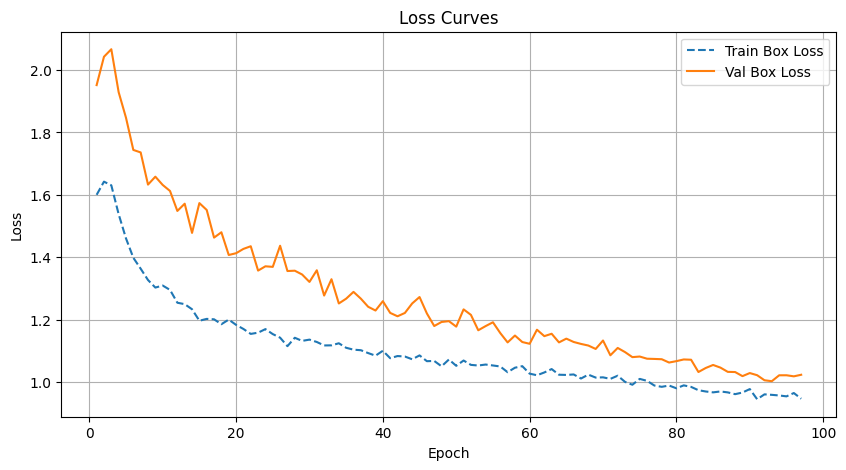

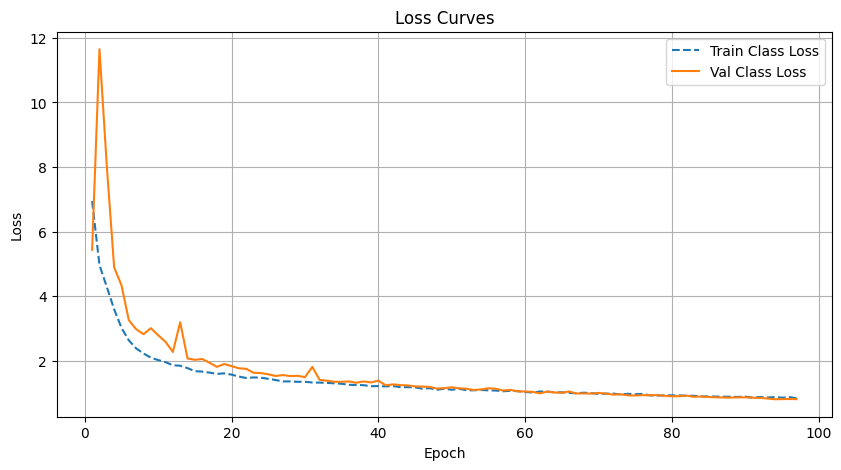

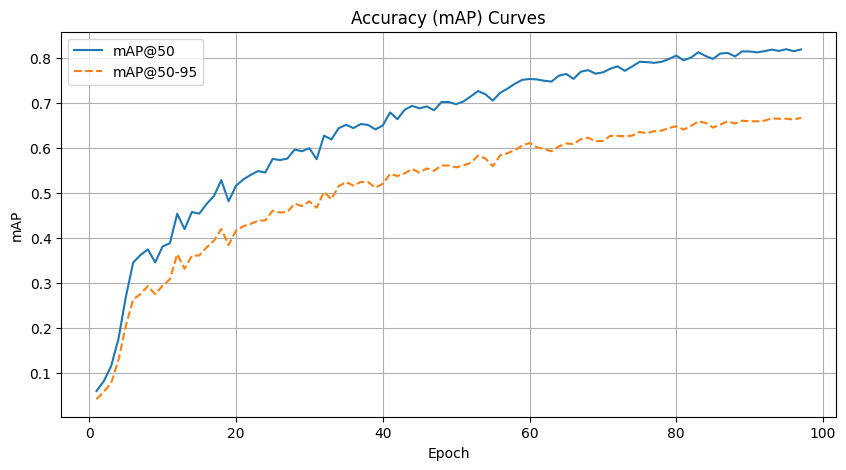

In [37]:
# Load the CSV file
results_path = "/content/runs/train/yolo12n_final_tuned2/results.csv"  # Update path if needed
df = pd.read_csv(results_path)

# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# Now, plot the curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
# Plot mAP Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Accuracy (mAP) Curves')
plt.legend()
plt.grid()
plt.show()

In [38]:
from ultralytics import YOLO

# Load YOLOv12n model
model = YOLO('yolo12n.pt')

# Train using tuned hyperparameters
model.train(
    data='/content/final_dataset/data.yaml',
    epochs=50,
    patience=10,
    imgsz=640,
    batch=32,
    optimizer='AdamW',
    lr0=0.00951,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.00064,
    warmup_epochs=2.3222,
    warmup_momentum=0.86382,
    box=8.77808,
    cls=0.60548,
    dfl=1.6372,
    hsv_h=0.01259,
    hsv_s=0.7287,
    hsv_v=0.44796,
    degrees=0.0,
    translate=0.10775,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.45382,
    bgr=0.0,
    mosaic=0.91831,
    mixup=0.0,
    cutmix=0.0,
    copy_paste=0.0,
    project='runs/train',
    name='yolo12n_final_tuned_3',
    verbose=True
)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=8.77808, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.60548, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.6372, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.45382, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01259, hsv_s=0.7287, hsv_v=0.44796, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00951, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=0.91831, multi_scale=False, name=yolo12n_final_tuned_3, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10

train: Scanning /content/final_dataset/train/labels.cache... 6143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6143/6143 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2032.6±1643.0 MB/s, size: 586.1 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]


Plotting labels to runs/train/yolo12n_final_tuned_3/labels.jpg... 
optimizer: AdamW(lr=0.00951, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00064), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/yolo12n_final_tuned_3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      13.8G      1.817        4.7      1.161         64        640: 100%|██████████| 192/192 [01:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


                   all        920       1155      0.184      0.161     0.0272     0.0168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.04G      1.671      3.358      1.121         68        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


                   all        920       1155       0.38      0.213     0.0903     0.0628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.04G      1.583       3.08      1.095         66        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


                   all        920       1155      0.557      0.217      0.149      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.04G      1.485      2.824       1.06         60        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


                   all        920       1155      0.483      0.237      0.142      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.04G      1.439      2.616      1.048         79        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


                   all        920       1155      0.432      0.306      0.225      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.04G        1.4      2.471      1.039         59        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


                   all        920       1155      0.448      0.323      0.244      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.04G      1.345       2.31      1.025         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


                   all        920       1155        0.4       0.37      0.286      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.04G       1.35      2.248      1.026         50        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


                   all        920       1155      0.375      0.354      0.268      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.04G       1.33      2.179       1.02         84        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


                   all        920       1155      0.491      0.387      0.377      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.04G      1.296      2.094      1.012         71        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


                   all        920       1155      0.429      0.456      0.372      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.04G      1.283      2.033      1.007         75        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


                   all        920       1155      0.571      0.384      0.365      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.04G      1.273       1.96      1.003         73        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


                   all        920       1155      0.437      0.403      0.387       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.04G      1.251      1.928      1.003         69        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]

                   all        920       1155      0.465      0.465      0.406      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.04G      1.238      1.863     0.9954         67        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


                   all        920       1155      0.506      0.458      0.434      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.04G        1.2      1.788     0.9882         66        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

                   all        920       1155      0.537      0.467      0.439      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.04G      1.216      1.787     0.9898         67        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]

                   all        920       1155      0.463      0.498      0.466      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.04G      1.197      1.758     0.9839         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


                   all        920       1155      0.482      0.462      0.418      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.04G      1.184      1.738     0.9848         80        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


                   all        920       1155      0.524      0.503      0.468      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.04G      1.193       1.71     0.9885         63        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

                   all        920       1155      0.501      0.479      0.463      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.04G      1.178      1.676     0.9849         70        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]

                   all        920       1155      0.531      0.499      0.488      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.04G      1.165      1.632     0.9786         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


                   all        920       1155      0.672      0.459      0.492      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.04G      1.165      1.605     0.9815         76        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]

                   all        920       1155      0.618      0.475       0.51      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.04G      1.164      1.601     0.9776         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


                   all        920       1155      0.494      0.515      0.494      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.04G       1.17      1.579     0.9778         64        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]

                   all        920       1155      0.589      0.484      0.498      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.04G      1.149      1.548     0.9754         67        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

                   all        920       1155      0.583      0.531      0.534       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.04G      1.131      1.507     0.9737         81        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


                   all        920       1155      0.594      0.529      0.536      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.04G      1.137      1.498     0.9743         64        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


                   all        920       1155      0.576      0.517      0.523      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.04G      1.132      1.496      0.968         69        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


                   all        920       1155      0.673      0.491      0.537      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.04G      1.116      1.457     0.9691         67        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


                   all        920       1155      0.584      0.538      0.541      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.04G      1.124      1.471     0.9692         70        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


                   all        920       1155      0.611      0.537      0.545       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.04G      1.129      1.454     0.9736         63        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

                   all        920       1155      0.609      0.541      0.557      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.04G      1.107      1.383     0.9663         65        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


                   all        920       1155      0.622      0.543      0.554      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.04G      1.101      1.407     0.9625         62        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


                   all        920       1155      0.639      0.525      0.554      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.04G      1.108      1.382     0.9657         66        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


                   all        920       1155      0.728       0.51      0.568       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.04G      1.091      1.367     0.9618         56        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


                   all        920       1155      0.655      0.548       0.57      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.04G      1.091      1.343     0.9595         68        640: 100%|██████████| 192/192 [01:25<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


                   all        920       1155      0.657      0.568      0.581      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.04G      1.081      1.323     0.9576         76        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


                   all        920       1155      0.692      0.551      0.593      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.04G      1.065      1.312      0.956         62        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


                   all        920       1155      0.662      0.557       0.58      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.04G      1.067      1.263     0.9591         73        640: 100%|██████████| 192/192 [01:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


                   all        920       1155      0.698       0.55      0.594      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.04G      1.067       1.29     0.9604         55        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


                   all        920       1155      0.748      0.537      0.594      0.493
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.04G       1.05      1.238      0.959         34        640: 100%|██████████| 192/192 [01:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


                   all        920       1155      0.635      0.556      0.585      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.04G       1.05      1.226     0.9612         38        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


                   all        920       1155      0.663      0.535       0.59      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.04G      1.038      1.184     0.9595         41        640: 100%|██████████| 192/192 [01:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


                   all        920       1155      0.702      0.551      0.595      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.04G      1.021      1.181     0.9514         35        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


                   all        920       1155      0.686      0.557      0.601      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.04G      1.026      1.144     0.9554         34        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


                   all        920       1155      0.739       0.55      0.605      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.04G      1.011      1.127     0.9549         35        640: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]

                   all        920       1155      0.676      0.575      0.604      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.04G      1.009      1.109     0.9525         32        640: 100%|██████████| 192/192 [01:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


                   all        920       1155      0.788      0.546       0.62      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.04G      1.002      1.095       0.95         30        640: 100%|██████████| 192/192 [01:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


                   all        920       1155       0.75      0.533      0.611      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.04G     0.9964      1.075     0.9516         40        640: 100%|██████████| 192/192 [01:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


                   all        920       1155      0.699      0.575       0.62      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.04G     0.9899      1.065     0.9493         36        640: 100%|██████████| 192/192 [01:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


                   all        920       1155      0.721      0.576      0.623      0.515

50 epochs completed in 0.983 hours.
Optimizer stripped from runs/train/yolo12n_final_tuned_3/weights/last.pt, 5.6MB
Optimizer stripped from runs/train/yolo12n_final_tuned_3/weights/best.pt, 5.6MB

Validating runs/train/yolo12n_final_tuned_3/weights/best.pt...
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12n summary (fused): 159 layers, 2,583,739 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


                   all        920       1155       0.73       0.56      0.622      0.514
                APR-09         15         15      0.814      0.584      0.577      0.436
                APR-10          7          7      0.733      0.714      0.867      0.691
                APR-11         13         13      0.917      0.923      0.982      0.721
                APR-12         21         21       0.69      0.619      0.639       0.49
                APR-14          8          8      0.541      0.375      0.493      0.346
                DWS-01         31         31      0.858      0.935      0.971      0.881
                DWS-02         34         34      0.908      0.941      0.963      0.855
                DWS-03         24         24      0.794      0.958      0.961      0.868
                DWS-04         16         16      0.764      0.809      0.895      0.806
                DWS-10         11         11      0.801      0.909      0.908      0.713
                DWS-1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 17, 18, 19, 21, 22, 23, 27, 28, 29, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2a222d9590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

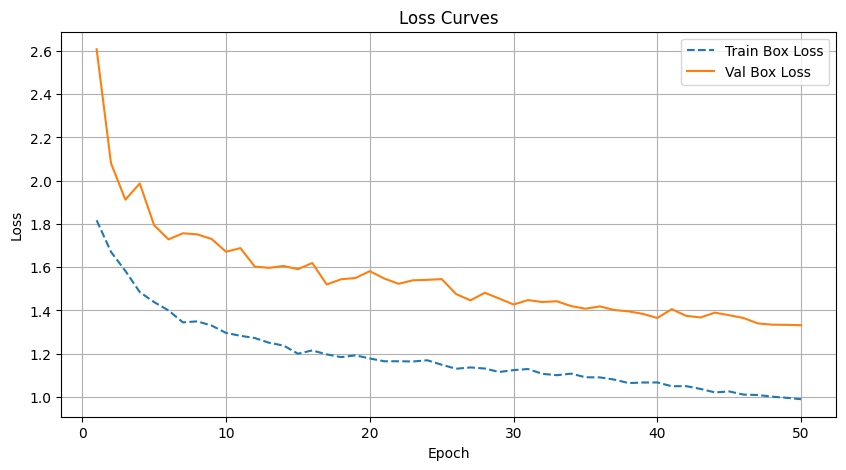

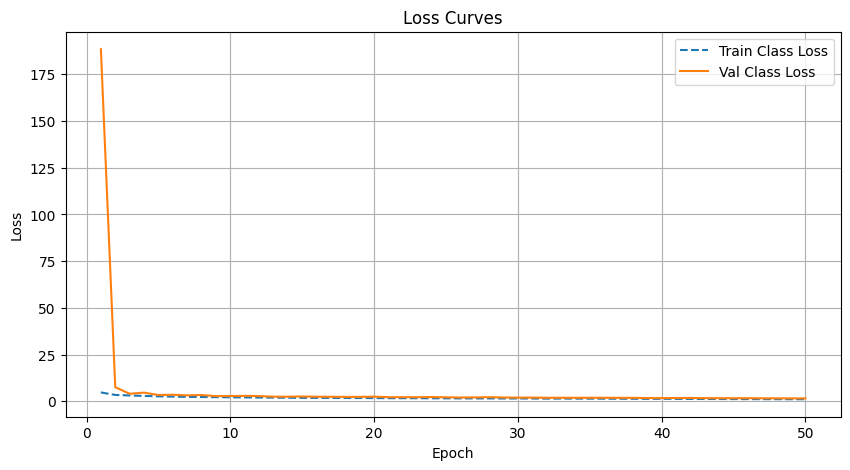

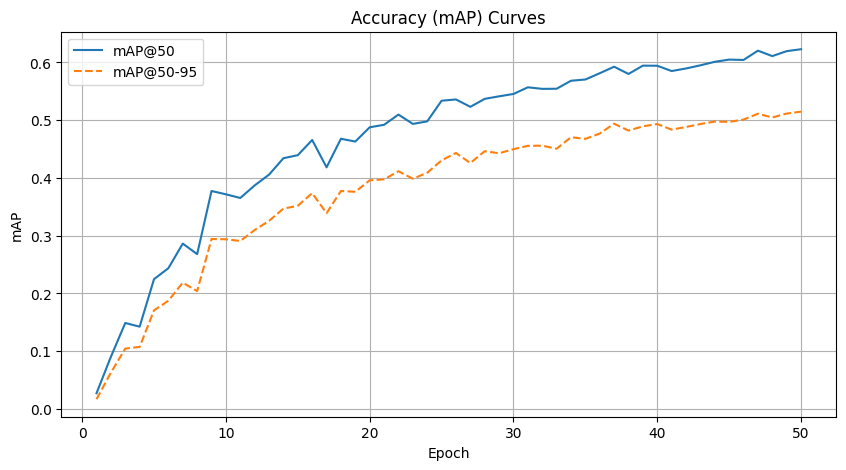

In [39]:
# Load the CSV file
results_path = "/content/runs/train/yolo12n_final_tuned_3/results.csv"  # Update path if needed
df = pd.read_csv(results_path)

# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# Now, plot the curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
# Plot mAP Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Accuracy (mAP) Curves')
plt.legend()
plt.grid()
plt.show()

In [ ]:

from ultralytics import YOLO

# Load YOLOv12n model
model = YOLO('yolo12n.pt')

# Train using tuned hyperparameters
model.train(
    data='/content/final_dataset/data.yaml',
    epochs=30,
    patience=10,
    imgsz=640,
    batch=64,
    optimizer='AdamW',
    lr0=0.000127,
    momentum=0.937,
    weight_decay=0.00064,
    warmup_epochs=2.3222,
    warmup_momentum=0.86382,
    box=8.77808,
    cls=0.60548,
    dfl=1.6372,
    hsv_h=0.01259,
    hsv_s=0.7287,
    hsv_v=0.44796,
    degrees=0.0,
    translate=0.10775,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.45382,
    bgr=0.0,
    mosaic=0.91831,
    mixup=0.0,
    cutmix=0.0,
    copy_paste=0.0,
    project='runs/train',
    name='yolo12n_final_tuned_3',
    verbose=True
)

New https://pypi.org/project/ultralytics/8.3.144 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=8.77808, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.60548, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.6372, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.45382, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01259, hsv_s=0.7287, hsv_v=0.44796, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.000127, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=0.91831, multi_scale=False, name=yolo12n_final_

train: Scanning /content/final_dataset/train/labels.cache... 6143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6143/6143 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1548.8±1245.9 MB/s, size: 586.1 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]


Plotting labels to runs/train/yolo12n_final_tuned_32/labels.jpg... 
optimizer: AdamW(lr=0.000127, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00064), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/yolo12n_final_tuned_32
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      13.4G      1.645      5.976       1.07        128        640: 100%|██████████| 96/96 [01:07<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

                   all        920       1155          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      13.4G      1.521      4.158      1.041        147        640: 100%|██████████| 96/96 [01:07<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.531     0.0998     0.0827     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      13.4G      1.424      3.481      1.016        123        640: 100%|██████████| 96/96 [01:07<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.456      0.197      0.143      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      13.4G      1.355      3.118      1.004        148        640: 100%|██████████| 96/96 [01:07<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.534      0.233      0.194      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      13.4G      1.316      2.837     0.9955        168        640: 100%|██████████| 96/96 [01:07<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


                   all        920       1155      0.466      0.269      0.242      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      13.4G       1.27       2.61     0.9919        151        640:  66%|██████▌   | 63/96 [00:44<00:23,  1.43it/s]